<a href="https://colab.research.google.com/github/nabeel-gulzar/k-nearest-neighbors/blob/master/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv
import time
from math import sqrt, floor
from random import randint
import pandas as pd
import numpy as np
import re, string
from collections import Counter
from itertools import dropwhile
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import KeyedVectors

<h1>Preprocessing and Data Preparation</h1>
<h2>This Part of Code is Shared in all Parts of Assignment</h2>


In [ ]:
garbage_words_re = r"(@|#|http|https)[();:',.\/@#$%*+!`^_A-Za-z0-9]*|[();:',.\/@#$%*+!`^_\d]|\""
test_ks = [1,3,5,7,10]
train_csv_path = 'data/train/train.csv'
test_csv_path = 'data/test/test.csv'
x_axis_labels=[str(k) for k in test_ks]
x_axis_groups=['Accuracy', 'Precision', 'Recall', 'F1']
preprocessed_embedding_path = 'data/GoogleNews-vectors-negative300.bin.gz'

In [ ]:
def remove_stopwords(string, stopwords):
    """
    removes all the stopwords from the given string
    Params:
    string - string from which to remove stopwords
    stopwords - string of stopwords separated by space
    Returns:
    string without the stopwords
    """
    return ' '.join(['' if word in stopwords else word for word in string.split()])

def generate_vocab(tweets, stopwords):
    """
    generates a list of vocabulary
    Params:
    tweets - a list of tweets (string) that is the basis of vocabulary
    stopwords - string of stopwords separated by space
    Returns:
    a list of vocabulary
    """
    vocab = []
    text = ' '.join(tweets)
    text = text.lower()
    if len(stopwords):
        text = remove_stopwords(text, stopwords)
    text = re.sub(garbage_words_re, '', text)
    text = text.split()
    vocab = Counter(text)
#    if args['remove_singles']:
#        for k, c in dropwhile(lambda item: item[1]>1, vocab.most_common()):
#            del vocab[k]
    return vocab

def tokenize(text, stopwords):
    """
    tokenizes the string after applying preprocessing
    Params:
    text - string to tokenize
    stopwords - string of stopwords separated by space
    Returns:
    list of tokens (words)
    """
    text = text.lower()
    if len(stopwords):
        text = remove_stopwords(text, stopwords)
    text = re.sub(garbage_words_re, '', text)
    words = text.split()
    return words

In [ ]:
#Label = { 'positive': 1, 'negative': -1, 'neutral': 0 }
#labels = [-1, 0, 1]
def create_bow(tweets, labels, vocabulary, stopwords):
    """
    creates a bag of word matrix
    Params:
    tweets - list of tweets
    labels - a list of labels
    vocabulary - list of vocabulary words
    stopwords - string of stopwords separated by space
    Returns:
    bag of words matrix
    """
    vocabulary = list(vocabulary)
    vocab_size = len(vocabulary)
    sample_size = len(tweets)
    data_x = np.zeros((sample_size, vocab_size))
    for i, sample in enumerate(tweets):
        for word in tokenize(sample, stopwords):
            try:
                word_index = vocabulary.index(word)
                data_x[i][word_index] += 1
            except:
                pass
    return data_x, [l for l in labels]

In [ ]:
def compute_distance_matrix(training_x, test_x):
    """
    computes distance matrix using euclidean distance
    Params:
    training_x - feature matrix of training data
    test_x - feature matrix of test data
    Returns:
    distance matrix (Test samples x Train samples)
    """
    return distance.cdist(test_x, training_x, 'euclidean')

In [ ]:
def divide(lst, l, r):       
    x = lst[r] 
    i = l 
    for j in range(l, r): 
        if lst[j] <= x: 
            lst[i], lst[j] = lst[j], lst[i] 
            i += 1              
    lst[i], lst[r] = lst[r], lst[i] 
    return i 

def quick_select(lst, l, r, k): 
    if (k > 0 and k <= r - l + 1): 
        index = divide(lst, l, r) 
        if (index - l == k - 1): 
            return lst[index] 
        if (index - l > k - 1): 
            return quick_select(lst, l, index - 1, k) 
        return quick_select(lst, index + 1, r, k - index + l - 1) 
    return 999999

def get_kth_smallest(lst, k):
    n = len(lst) 
    return quick_select(lst, 0, n - 1, k)

def get_k_nearest_indexes(distance_vector, k):
    """
    generator that generates the indexes of the k nearest samples of train_i in train vector
    Params:
    distance_vector - a vector of distance between a specific test sample and all training samples
    k - number of nearest neighbors
    Returns:
    list of k indexes in training samples that are nearest
    """
    temp_distance = np.array(distance_vector)
    kth_smallest = get_kth_smallest(temp_distance, k)
    for i, d in enumerate(distance_vector):
        if d <= kth_smallest:
            yield i

def get_mod(lst):
    """
    returns mod of the list can be more than one
    Params:
    lst - list on which mod needs to be computed
    Returns:
    mod of the list (list)
    """
    label_counter = Counter(lst)
    max_count = label_counter.most_common(1)[0][1]
    return [k for k, c in label_counter.items() if c == max_count]
    
def assign_label(distance_matrix, training_labels, k):
    """
    computes label for a particular test example backs off to 1 if more that one label
    if on k=1 is still not clear. use random label from nearest neighbors
    Params:
    distance_matrix - matrix containing distance between test and training examples
    Returns:
    label for the test sample
    """
    k_nearest_labels = [training_labels[i] for i in get_k_nearest_indexes(distance_matrix, k)]
    mod = get_mod(k_nearest_labels)
    if len(mod) > 1:
        if k == 1:
            return mod[randint(0, len(mod) - 1)]
        return assign_label(distance_matrix, training_labels, k-1)
    return mod[0]

def predict(distance_matrix, training_y, k):
    """
    predicts labels for a list of training samples
    Params:
    distance_matrix - matrix contaning distance between training and test samples
    training_y - true labels vector
    k - k for nearest neighbors
    Returns:
    vector of predicted labels
    """
    test_size = distance_matrix.shape[0]
    return [assign_label(distance_matrix[test_i], training_y, k) for test_i in range(test_size)]

def generate_confusion_matrix(gold, prediction, labels):
    """
    generates a confusion matrix
    Params:
    gold - vector of true labels
    predicted - vector of predicted labels
    labels: list of distinct labels
    Returns:
    confusion matrix with shape (label count X label count)
    """
    if len(gold) != len(prediction):
        print('label arrays should have same size')
        return
    label_count = len(labels)
    cm = np.zeros((label_count, label_count))
    for i in range(len(prediction)):
        cm[labels.index(prediction[i])][labels.index(gold[i])] += 1
    return cm

In [ ]:
def compute_macro_average(prediction, gold, labels):
    """
    computes macro average (precision, recall, f1) confusion_matrix and accuracy
    Params:
    prediction - vector of predicted labels
    gold - vector of true labels
    labels: list of distinct labels
    Returns:
    dictionary of {precision, recall, f1, confusion_matrix, accuracy}
    """
    if len(gold) != len(prediction):
        print('label arrays should have same size')
        return
    label_count = len(labels)
    cm = generate_confusion_matrix(test_y, prediction, labels)
    precision = 0
    recall = 0
    accuracy = 0
    for i in range(label_count):
        negatives = [n for n in range(label_count) if n != i]
        tp = cm[i][i]
        fn = np.array([cm[j][i] for j in negatives]).sum()
        fp = np.array([cm[i][j] for j in negatives]).sum()
        tn = np.array([np.array([cm[j][k] for j in negatives]).sum() for k in negatives]).sum()

        precision += (tp/(tp+fp))
        recall += (tp/(tp+fn))
        accuracy += tp
    accuracy = accuracy/len(prediction)
    macro_avg_precision = precision/label_count
    macro_avg_recall = recall/label_count
    f1_score = (2*macro_avg_precision*macro_avg_recall)/(macro_avg_precision+macro_avg_recall)
    return {'f1': f1_score,
            'precision': macro_avg_precision,
            'recall': macro_avg_recall,
            'accuracy': accuracy,
            'confusion_matrix': cm}

In [ ]:
def plot_performance(a, b, c, d, labels, groups):
    """
    plots multibar chart with k on x-axis and performance measures of y axis
    Params:
    a, b, c, d - precision, recall, f1, accuracy (in order with groups)
    labels: list of distinct labels
    Returns:
    """
    ind = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 12)
    bar1 = ax.bar(ind - (1.5*width), a, width, label=groups[0])
    bar2 = ax.bar(ind - (width/2), b, width, label=groups[1])
    bar3 = ax.bar(ind + (width/2), c, width, label=groups[2])
    bar4 = ax.bar(ind + (1.5*width), d, width, label=groups[3])

    ax.set_ylabel('Performance')
    ax.set_xlabel('K')
    ax.set_title('Performance Analysis of KNN with respective Ks')
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.set_ylim([0,1])
    ax.legend()

    def annotate(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    annotate(bar1)
    annotate(bar2)
    annotate(bar3)
    annotate(bar4)
    fig.tight_layout()
    plt.show()

In [ ]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

stopwords = []
with open('data/stop_words.txt', 'r') as fd:
    stopwords = fd.read().split('\n')

In [ ]:
starttime = time.time()
vocabulary = generate_vocab(train_df['Tweet'], stopwords)
training_x, training_y = create_bow(train_df['Tweet'], train_df['Sentiment'], vocabulary, stopwords)
test_x, test_y = create_bow(test_df['Tweet'], test_df['Sentiment'], vocabulary, stopwords)
endtime = time.time()
print('Time taken to create BOW: {:.2f} seconds'.format(endtime - starttime))

Time taken to create BOW: 3.34 seconds


<h1>Part 1</h1>

In [ ]:
print('computing distance matrix...')
starttime = time.time()
distance_matrix = compute_distance_matrix(training_x, test_x)
endtime = time.time()
print('distance matrix computed in {:.2f} seconds'.format(endtime - starttime))

computing distance matrix...
distance matrix computed in 206.69 seconds


<h3>Self Implemented KNN</h3>

In [ ]:
accuracies = []
f1s = []
precisions = []
recalls = []
for k in test_ks:
    print('starting prediction for k={}'.format(k))
    starttime = time.time()
    prediction = predict(distance_matrix, training_y, k)
    endtime = time.time()
    print('prediction completed in {:.2f} seconds'.format(endtime-starttime))
    macro = compute_macro_average(prediction, test_y, ['negative', 'positive', 'neutral'])
    accuracy = macro['accuracy']
    f1 = macro['f1']
    precision = macro['precision']
    recall = macro['recall']

    accuracies.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    
    cm = macro['confusion_matrix']
    print('Report For for K={}'.format(k))
    print('Confusion Matrix')
    print(cm)
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}\n'.format(f1))
    print('------------------------')

starting prediction for k=1
prediction completed in 33.54 seconds
Report For for K=1
Confusion Matrix
[[844.  54.  96.]
 [285. 323. 160.]
 [705.  95. 359.]]
Accuracy: 0.52
Precision: 0.53
Recall: 0.58
F1: 0.55

------------------------
starting prediction for k=3
prediction completed in 42.73 seconds
Report For for K=3
Confusion Matrix
[[805.  45.  77.]
 [278. 326. 141.]
 [751. 101. 397.]]
Accuracy: 0.52
Precision: 0.54
Recall: 0.59
F1: 0.57

------------------------
starting prediction for k=5
prediction completed in 49.09 seconds
Report For for K=5
Confusion Matrix
[[745.  39.  61.]
 [259. 320. 132.]
 [830. 113. 422.]]
Accuracy: 0.51
Precision: 0.55
Recall: 0.59
F1: 0.57

------------------------
starting prediction for k=7
prediction completed in 49.83 seconds
Report For for K=7
Confusion Matrix
[[672.  33.  41.]
 [236. 314. 120.]
 [926. 125. 454.]]
Accuracy: 0.49
Precision: 0.56
Recall: 0.59
F1: 0.57

------------------------
starting prediction for k=10
prediction completed in 52.

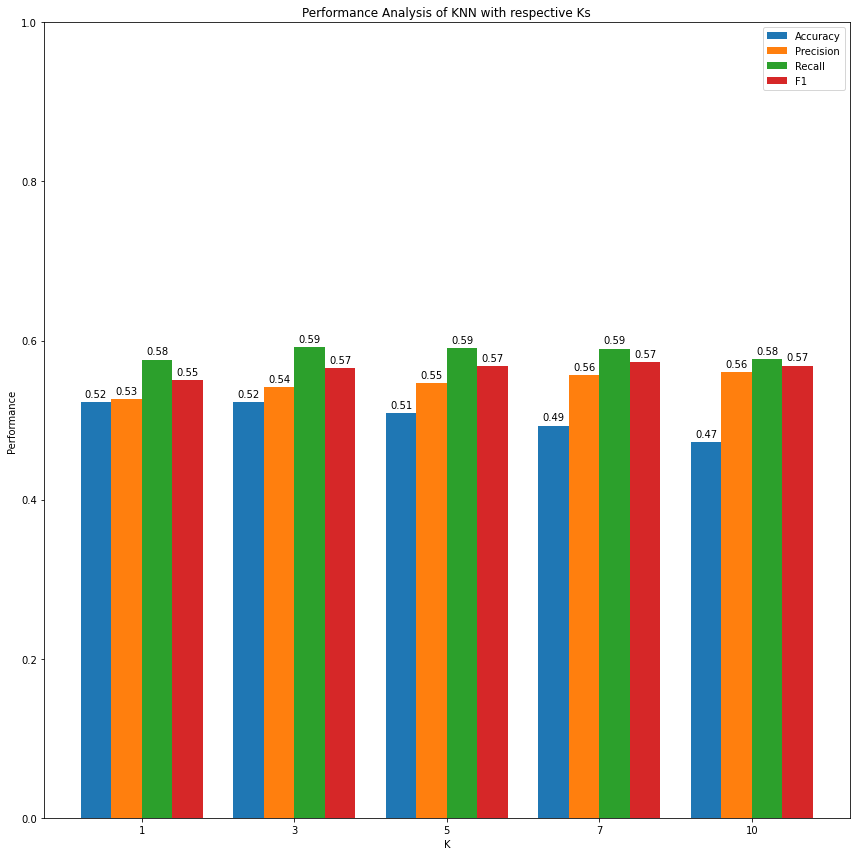

In [ ]:
plot_performance(accuracies, precisions, recalls, f1s, x_axis_labels, x_axis_groups)

<h1>Part 2</h1>
<h2>sklearn KNN implementation</h2>

In [ ]:
accuracies = []
f1s = []
precisions = []
recalls = []
for k in test_ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(training_x, training_y)
    print('starting prediction for k={}'.format(k))
    starttime = time.time()
    y_hat = knn.predict(test_x)
    endtime = time.time()
    print('prediction completed in {:.2f} seconds'.format(endtime-starttime))
    accuracy = accuracy_score(test_y, y_hat)
    precision, recall, f1, _ = precision_recall_fscore_support(test_y, y_hat, average='macro')
    cm = confusion_matrix(test_y, y_hat)
    accuracies.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    
    print('Report For for K={}'.format(k))
    print('Confusion Matrix')
    print(cm)
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}\n'.format(f1))
    
    report = classification_report(test_y, y_hat, target_names=['negative', 'neutral', 'positive'])
    print('Classification Report')
    print(report)

starting prediction for k=1
prediction completed in 569.67 seconds
Report For for K=1
Confusion Matrix
[[884 697 253]
 [116 387 112]
 [ 64 135 273]]
Accuracy: 0.53
Precision: 0.53
Recall: 0.56
F1: 0.51

Classification Report
              precision    recall  f1-score   support

    negative       0.83      0.48      0.61      1834
     neutral       0.32      0.63      0.42       615
    positive       0.43      0.58      0.49       472

    accuracy                           0.53      2921
   macro avg       0.53      0.56      0.51      2921
weighted avg       0.66      0.53      0.55      2921

starting prediction for k=3
prediction completed in 624.54 seconds
Report For for K=3
Confusion Matrix
[[955 692 187]
 [147 356 112]
 [ 78 126 268]]
Accuracy: 0.54
Precision: 0.53
Recall: 0.56
F1: 0.52

Classification Report
              precision    recall  f1-score   support

    negative       0.81      0.52      0.63      1834
     neutral       0.30      0.58      0.40       615
    po

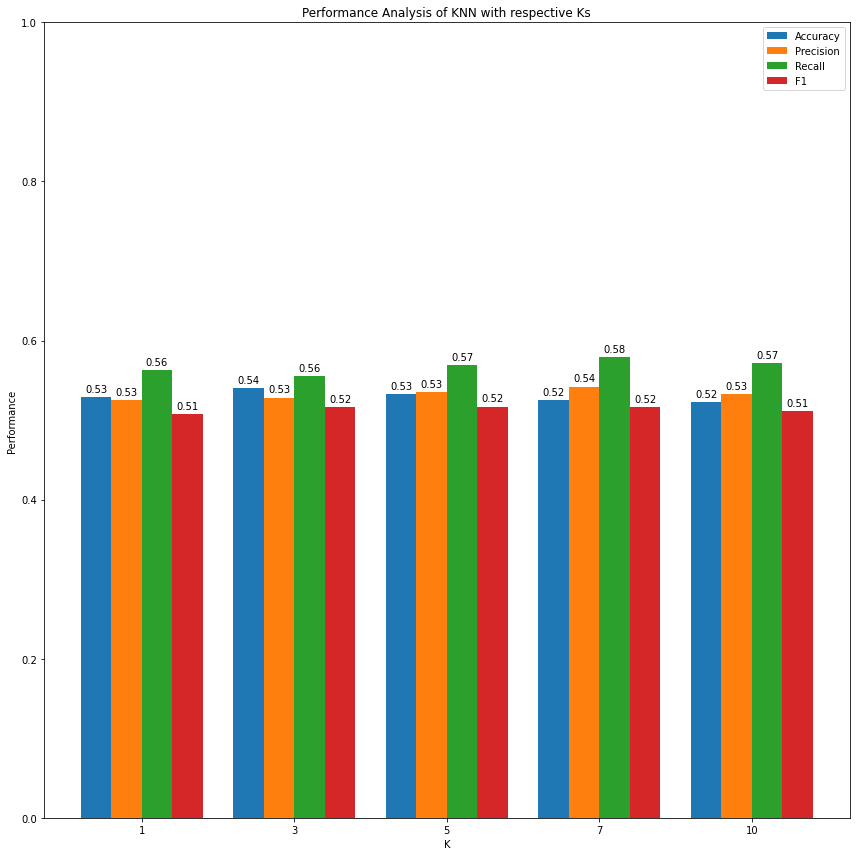

In [ ]:
plot_performance(accuracies, precisions, recalls, f1s, x_axis_labels, x_axis_groups)

<h1>Part 3</h1>

In [ ]:
word2vec = KeyedVectors.load_word2vec_format(preprocessed_embedding_path, binary=True)

In [ ]:
def create_embedding_matrix(lst, stopwords):
    embeddings = []
    empty_indexes = []
    for i, text in enumerate(lst):
        words = [word for word in tokenize(text, stopwords) if word in word2vec.vocab]
        if not len(words):
            empty_indexes.append(i)
            continue
        feature_vector = np.mean(word2vec[words], axis=0)
        embeddings.append(feature_vector)
    return embeddings, empty_indexes
train_x_emb, empty_indexes_tr = create_embedding_matrix(train_df['Tweet'], stopwords)
test_x_emb, empty_indexes_ts = create_embedding_matrix(test_df['Tweet'], stopwords)

In [ ]:
training_y = [l for i, l in enumerate(training_y) if i not in empty_indexes_tr]
test_y = [l for i, l in enumerate(test_y) if i not in empty_indexes_ts]

<h3>Self Implemented KNN with word2vec embeddings</h3>

In [ ]:
print('computing distance matrix...')
starttime = time.time()
distance_matrix = compute_distance_matrix(train_x_emb, test_x_emb)
endtime = time.time()
print('distance matrix computed in {:.2f} seconds'.format(endtime - starttime))

computing distance matrix...
distance matrix computed in 6.53 seconds


starting prediction for k=1
prediction completed in 26.08 seconds
Report For for K=1
Confusion Matrix
[[1549.  166.  298.]
 [ 122.  241.   85.]
 [ 162.   65.  227.]]
Accuracy: 0.69
Precision: 0.60
Recall: 0.58
F1: 0.59

------------------------
starting prediction for k=3
prediction completed in 27.87 seconds
Report For for K=3
Confusion Matrix
[[1702.  170.  356.]
 [  60.  258.   69.]
 [  71.   44.  185.]]
Accuracy: 0.74
Precision: 0.68
Recall: 0.59
F1: 0.63

------------------------
starting prediction for k=5
prediction completed in 28.98 seconds
Report For for K=5
Confusion Matrix
[[1750.  180.  401.]
 [  38.  261.   61.]
 [  45.   31.  148.]]
Accuracy: 0.74
Precision: 0.71
Recall: 0.58
F1: 0.64

------------------------
starting prediction for k=7
prediction completed in 26.95 seconds
Report For for K=7
Confusion Matrix
[[1773.  190.  427.]
 [  28.  255.   50.]
 [  32.   27.  133.]]
Accuracy: 0.74
Precision: 0.73
Recall: 0.58
F1: 0.64

------------------------
starting prediction 

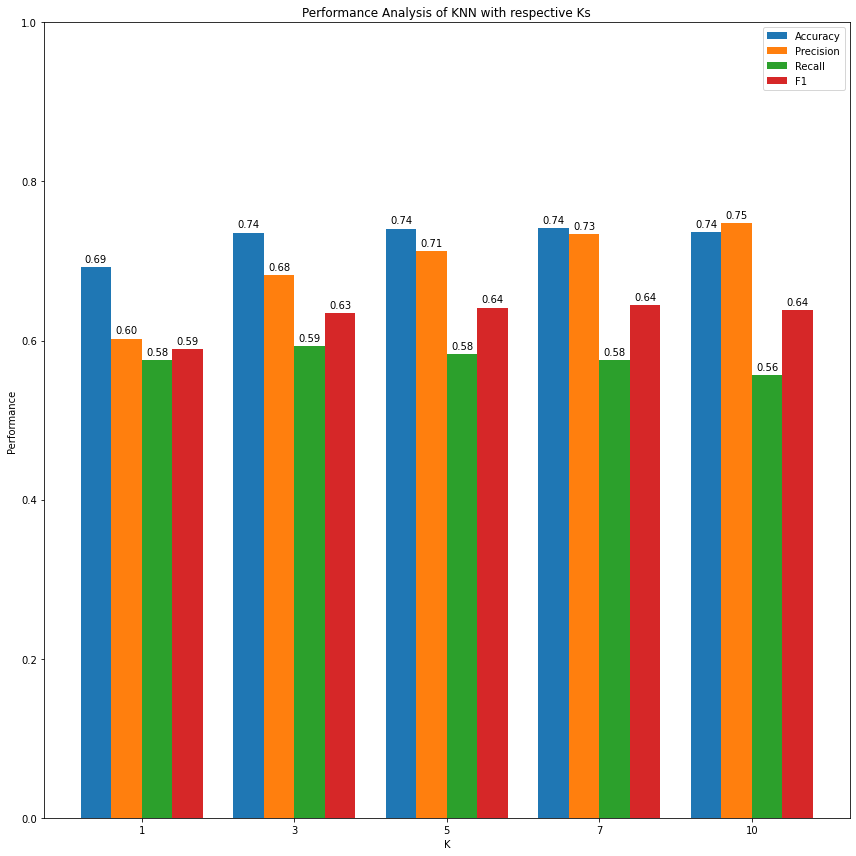

In [ ]:
accuracies = []
f1s = []
precisions = []
recalls = []
for k in test_ks:
    print('starting prediction for k={}'.format(k))
    starttime = time.time()
    prediction = predict(distance_matrix, training_y, k)
    endtime = time.time()
    print('prediction completed in {:.2f} seconds'.format(endtime-starttime))
    macro = compute_macro_average(prediction, test_y, ['negative', 'positive', 'neutral'])
    accuracy = macro['accuracy']
    f1 = macro['f1']
    precision = macro['precision']
    recall = macro['recall']

    accuracies.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    
    cm = macro['confusion_matrix']
    print('Report For for K={}'.format(k))
    print('Confusion Matrix')
    print(cm)
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}\n'.format(f1))
    print('------------------------')
plot_performance(accuracies, precisions, recalls, f1s, x_axis_labels, x_axis_groups)

<h3>sklearn KNN with word2vec embeddings</h3>

(11645, 300)
(2915, 300)
starting prediction for k=1
prediction completed in 17.22 seconds
Report For for K=1
Confusion Matrix
<function confusion_matrix at 0x7f1241814d08>
Accuracy: 0.69
Precision: 0.59
Recall: 0.56
F1: 0.57

Classification Report
              precision    recall  f1-score   support

    negative       0.77      0.85      0.80      1833
     neutral       0.48      0.36      0.41       610
    positive       0.53      0.49      0.51       472

    accuracy                           0.69      2915
   macro avg       0.59      0.56      0.57      2915
weighted avg       0.67      0.69      0.67      2915

-------------------------
starting prediction for k=3
prediction completed in 17.21 seconds
Report For for K=3
Confusion Matrix
<function confusion_matrix at 0x7f1241814d08>
Accuracy: 0.73
Precision: 0.69
Recall: 0.57
F1: 0.60

Classification Report
              precision    recall  f1-score   support

    negative       0.75      0.94      0.83      1833
     neutra

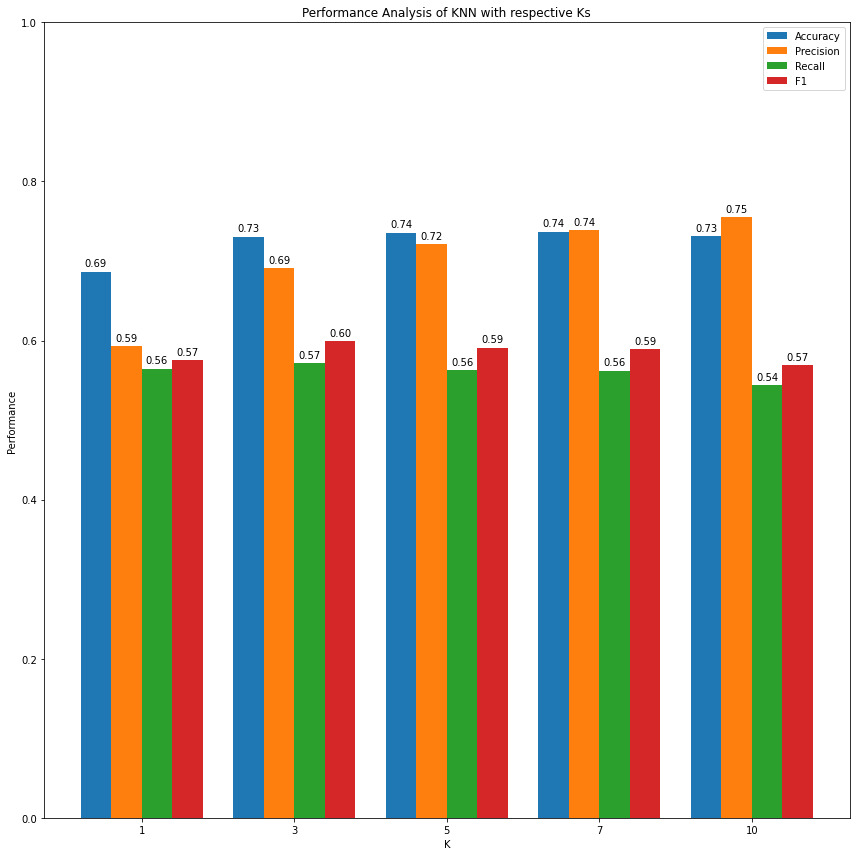

In [ ]:
accuracies = []
f1s = []
precisions = []
recalls = []
print(np.array(train_x_emb).shape)
print(np.array(test_x_emb).shape)
for k in test_ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(train_x_emb, training_y)
    print('starting prediction for k={}'.format(k))
    starttime = time.time()
    y_hat = knn.predict(test_x_emb)
    endtime = time.time()
    print('prediction completed in {:.2f} seconds'.format(endtime-starttime))
    accuracy = accuracy_score(test_y, y_hat)
    precision, recall, f1, _ = precision_recall_fscore_support(test_y, y_hat, average='macro')
    cm = confusion_matrix(test_y, y_hat)
    accuracies.append(accuracy)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    
    print('Report For for K={}'.format(k))
    print('Confusion Matrix')
    print(confusion_matrix)
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1: {:.2f}\n'.format(f1))
    
    report = classification_report(test_y, y_hat, target_names=['negative', 'neutral', 'positive'])
    print('Classification Report')
    print(report)
    print('-------------------------')
plot_performance(accuracies, precisions, recalls, f1s, x_axis_labels, x_axis_groups)